In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os, sys
import itertools
import pickle
import h5py

# local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from gtv import *
from preprocessing import *

# Note on detrending

When we performed this analysis, we detrended the SSTs using the entire dataset. As we move forward, given that this is a forecasting setting, we realize it is not best practice to use data from the period we are trying to forecast to compute trends. In this notebook, we present an overview of the impact of detrending and suggest some alternatives.

In [2]:
# load obs (this .csv was generated in the SST preprocessing script)
df = pd.read_csv('../data/SST_pacific_summer.csv')

For illustration, we take the average annual SST over the Pacific:

In [19]:
yrly_df = df.groupby(['year']).temp.mean().reset_index()

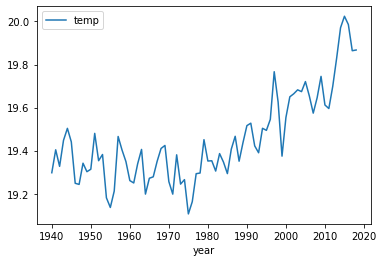

In [20]:
sns.set()

yrly_df.plot('year', 'temp')

In [514]:
prev = df[df.year.between(yr-window, yr-1)].groupby(['lat', 'lon', 'month']).temp.agg(['mean', 'std']).reset_index()

In [516]:
prev['year'] = yr

In [521]:
pd.merge(df, prev, on=['lat', 'lon', 'month', 'year'], how='left')

,lat,lon,time,temp,year,month,var,val,mean,std
0,60,155,6,8.293000,2018,july,sst,8.293000,8.535800,0.844158
1,60,156,6,8.339001,2018,july,sst,8.339001,8.534667,0.788069
2,60,157,6,8.646001,2018,july,sst,8.646001,8.791734,0.741156
3,60,158,6,8.650001,2018,july,sst,8.650001,8.742600,0.702980
4,60,159,6,8.604000,2018,july,sst,8.604000,8.644000,0.663200
...,...,...,...,...,...,...,...,...,...,...
78383,-59,275,9,3.770000,2018,oct,sst,3.770000,3.687333,0.237370
78384,-59,276,9,3.858000,2018,oct,sst,3.858000,3.712067,0.238753
78385,-59,277,9,3.793000,2018,oct,sst,3.793000,3.715667,0.236875
78386,-59,278,9,3.788000,2018,oct,sst,3.788000,3.671000,0.244761


In [522]:
t = df[df.year==yr]
prev = df[df.year.between(yr-window, yr-1)].groupby(['lat', 'lon', 'month']).temp.agg(['mean', 'std'])
prev['year'] = yr
t = pd.merge(t, prev, on=['lat', 'lon', 'month', 'year'])
t['anomaly'] = (t.temp - t['mean'])/t['std']

In [523]:
t

,lat,lon,time,temp,year,month,var,val,mean,std,anomaly
0,60,155,6,8.293000,2018,july,sst,8.293000,8.535800,0.844158,-0.287624
1,60,156,6,8.339001,2018,july,sst,8.339001,8.534667,0.788069,-0.248286
2,60,157,6,8.646001,2018,july,sst,8.646001,8.791734,0.741156,-0.196629
3,60,158,6,8.650001,2018,july,sst,8.650001,8.742600,0.702980,-0.131725
4,60,159,6,8.604000,2018,july,sst,8.604000,8.644000,0.663200,-0.060314
...,...,...,...,...,...,...,...,...,...,...,...
78383,-59,275,9,3.770000,2018,oct,sst,3.770000,3.687333,0.237370,0.348262
78384,-59,276,9,3.858000,2018,oct,sst,3.858000,3.712067,0.238753,0.611231
78385,-59,277,9,3.793000,2018,oct,sst,3.793000,3.715667,0.236875,0.326473
78386,-59,278,9,3.788000,2018,oct,sst,3.788000,3.671000,0.244761,0.478017


In [524]:
window = 10
dt = pd.DataFrame()
for yr in np.arange(1940+window, 2019):
    t = df[df.year==yr]
    prev = df[df.year.between(yr-window, yr-1)].groupby(['lat', 'lon', 'month']).temp.agg(['mean', 'std'])
    prev['year'] = yr
    t = pd.merge(t, prev, on=['lat', 'lon', 'month', 'year'])
    t['anomaly'] = (t.temp - t['mean'])/t['std']
    dt = dt.append(t, ignore_index=True)
    
dt['val'] = dt.anomaly
X_obs, fts, _ = monthly_X(dt, step=10, agg=True, scale=False)

In [541]:
dt['val'] = dt.anomaly
X_obs, fts, _ = monthly_X(dt, step=10, agg=True, scale=False)

In [556]:
Xnzi = X_obs[:, fts[fts.nzi>0].index].mean(axis=1).reshape(-1,1)

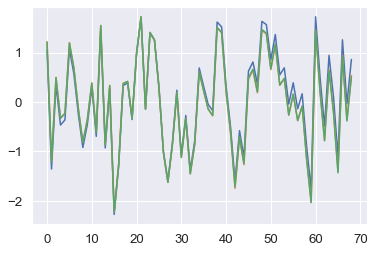

In [551]:
plt.plot(Xnzi)
plt.plot(signal.detrend(Xnzi, axis=0))
plt.plot(np.append(signal.detrend(Xnzi[:40], axis=0), signal.detrend(Xnzi[40:], axis=0)))

In [557]:
#Xnzi = signal.detrend(Xnzi)
lm = linear_model.LinearRegression()

lm.fit(Xnzi[:40], y[:40])
r2_score(y[50:70], lm.predict(Xnzi[40:60]))

-0.10359828533501414

In [543]:
pd.DataFrame(X_obs).to_csv('../data/X_obs_dt10.csv', index=False)

In [510]:
nzi = df_nzi.groupby('year').temp.mean().reset_index()
nzi['standardized'] = preprocessing.scale(nzi.temp)
window = i
for yr in np.arange(1940+window, 2019):
    x = nzi[nzi.year==yr].temp.values[0]
    prev = nzi[nzi.year.between(yr-window, yr-1)].temp.values
    nzi.loc[nzi.year==yr, 'anomaly_{}'.format(i)] = (x - np.mean(prev))/np.std(prev)

,lat,lon,time,temp,year,month,var,val
0,60,155,6,7.446001,1940,july,sst,7.446001
1,60,156,6,7.464000,1940,july,sst,7.464000
2,60,157,6,7.785000,1940,july,sst,7.785000
3,60,158,6,7.811000,1940,july,sst,7.811000
4,60,159,6,7.829000,1940,july,sst,7.829000
...,...,...,...,...,...,...,...,...
6192647,-59,275,9,3.770000,2018,oct,sst,3.770000
6192648,-59,276,9,3.858000,2018,oct,sst,3.858000
6192649,-59,277,9,3.793000,2018,oct,sst,3.793000
6192650,-59,278,9,3.788000,2018,oct,sst,3.788000


In [222]:
min_year = 1940
training_end = 1989

In [122]:
seasonal = df[(df.year.between(min_year, training_end))].groupby(['lat', 'lon', 'month']).val.agg(['mean', 'std']).reset_index()

In [223]:
df.head()

,lat,lon,time,temp,year,month,var,val
0,60,155,6,7.446001,1940,july,sst,7.446001
1,60,156,6,7.464000,1940,july,sst,7.464000
2,60,157,6,7.785000,1940,july,sst,7.785000
3,60,158,6,7.811000,1940,july,sst,7.811000
4,60,159,6,7.829000,1940,july,sst,7.829000


In [128]:
sst = pd.merge(df[['lat', 'lon', 'year', 'month', 'val']], seasonal, on=['lat', 'lon', 'month'])
sst['anomaly'] = (sst['val'] - sst['mean'])/sst['std']
sst['val'] = sst['anomaly']

In [182]:
X_train, fts, _ = monthly_X(sst, step=10, agg=True, scale=False, max_year=training_end)
X_test, _, _ = monthly_X(sst, step=10, agg=True, scale=False, min_year=training_end+1, max_year=2018)

In [183]:
n = 50
A = np.ones((n, 2))
A[:, 0] = (np.arange(1, n + 1))# * 1.0 / n)
coef, resids, rank, s = np.linalg.lstsq(A, X_train)

X_train_dt = X_train - A@coef #remove trend from training 

n_test = X_test.shape[0]
A_test = np.ones((n_test, 2))
A_test[:, 0] = (np.arange(1, X_test.shape[0]+1))
X_test_dt = X_test - A_test@coef # remove same training trend from test

In [171]:
fts['obs_ix'] = fts.index
fts_old = pd.read_csv('../data/sst_columns.csv')
fts = pd.merge(fts_old, fts)

In [172]:
pd.DataFrame(X_train[:, fts.obs_ix]).to_csv('../data/X_train_newdt.csv', index=False)
pd.DataFrame(X_test[:, fts.obs_ix]).to_csv('../data/X_test_newdt.csv', index=False)

In [175]:
X_obs = pd.read_csv('../data/X_obs.csv').values

In [189]:
Xnzi = X_obs[:, fts_old[fts_old.nzi!=0].index].mean(axis=1)

In [195]:
y = pd.read_csv("../data/y_avg.csv")

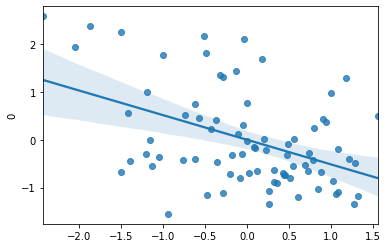

In [198]:
sns.regplot(Xnzi, y)

In [205]:
lm = linear_model.LinearRegression()
lm.fit(Xnzi[:50].reshape(-1,1), y[:50])
r2_score(y[50:], lm.predict(Xnzi[50:].reshape(-1,1)))

0.22624339534610383

In [460]:
nzi

,year,temp
0,1940,14.685584
1,1941,14.935501
2,1942,15.251417
3,1943,15.163084
4,1944,15.213084
...,...,...
74,2014,15.457251
75,2015,15.131417
76,2016,15.864751
77,2017,15.413084


<Figure size 1080x360 with 0 Axes>

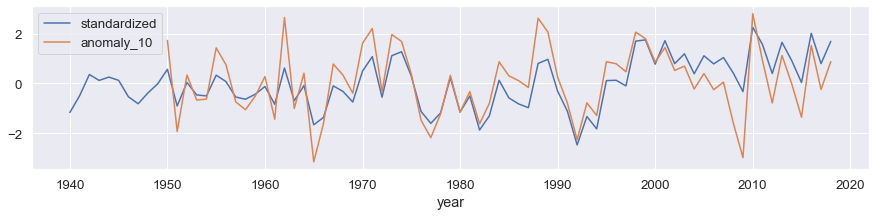

In [493]:
plt.figure(figsize=(15,5))
nzi[['year', 'standardized', 'anomaly_10']].plot(x='year', figsize=(15,3))

In [508]:
lm = linear_model.LinearRegression()
lm.fit(nzi.anomaly_10.dropna().values[:40].reshape(-1,1), y[10:50])
r2_score(y[50:70], lm.predict(nzi.anomaly_10.dropna().values[40:60].reshape(-1,1)))

0.21029365163378355

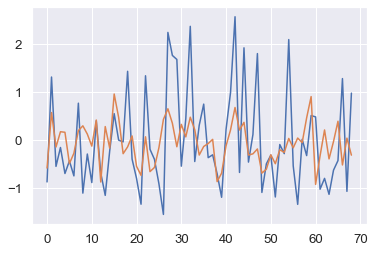

In [505]:
plt.plot(y.values[10:])
plt.plot(lm.predict(nzi.anomaly_10.dropna().values.reshape(-1,1)))

<Figure size 1080x360 with 0 Axes>

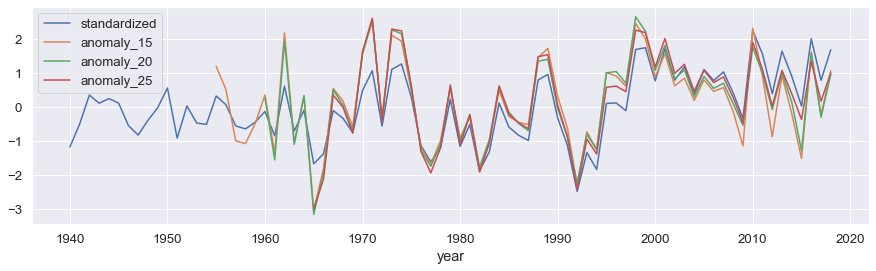

In [486]:
plt.figure(figsize=(15,5))
nzi.drop(columns=['temp', 'anomaly_10']).plot(x='year', figsize=(15,4))

In [364]:
df_nzi = pd.merge(df, fts[fts.nzi>0])
df_nzi['split'] = df_nzi.year.apply(lambda x: 'train' if x<=1989 else 'test')
seasonalnz1 = df_nzi[df_nzi.split=='train'].groupby(['lat', 'lon', 'month']).val.agg(['mean', 'std']).reset_index()
seasonalnz2 = df_nzi.groupby(['lat', 'lon', 'month']).val.agg(['mean', 'std']).reset_index()
df_nzi = pd.merge(df_nzi, seasonalnz2, on=['lat', 'lon', 'month'])
df_nzi = pd.merge(df_nzi, seasonalnz1, suffixes=['', '_train'], on=['lat', 'lon', 'month'])

In [365]:
df_nzi['anomaly_train'] = (df_nzi['val'] - df_nzi['mean_train'])/df_nzi['std_train']
df_nzi['anomaly'] = (df_nzi['val'] - df_nzi['mean'])/df_nzi['std']

In [366]:
yearly_anomalies = df_nzi.groupby('year')[['temp', 'anomaly', 'anomaly_train']].mean().reset_index()

Text(0.5, 1.0, 'Average summer SST over NZI')

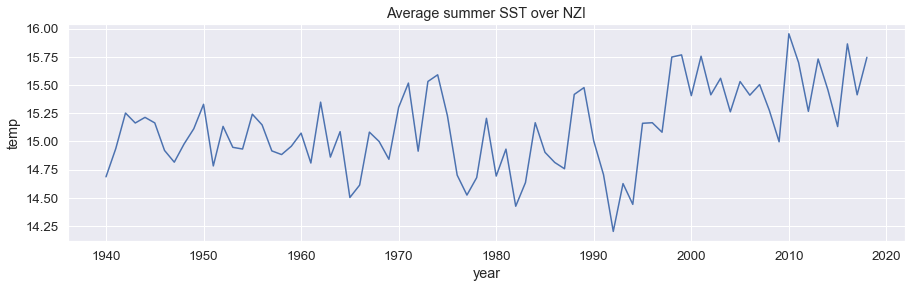

In [380]:
plt.figure(figsize=(15,4))
sns.lineplot(x='year', y='temp', data=yearly_anomalies)
sns.set(font_scale=1.2)
plt.title('Average summer SST over NZI')

Text(0.5, 1.0, 'NZI anomalies')

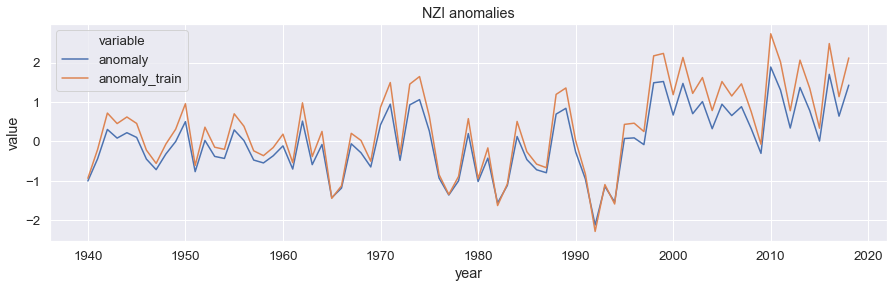

In [382]:
plt.figure(figsize=(15,4))
sns.lineplot(x='year', y='value', hue='variable', 
             data=yearly_anomalies[['year', 'anomaly', 'anomaly_train']].melt(id_vars='year'))
plt.title('NZI anomalies')

<Figure size 1080x360 with 0 Axes>

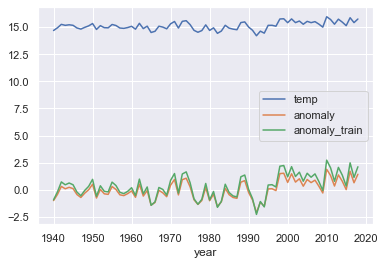

In [369]:
plt.figure(figsize=(15,5))
yearly_anomalies.plot(x='year')

In [274]:
lm.fit(yearly_anomalies.anomaly_train[:50].values.reshape(-1,1), y[:50])
r2_score(y[50:], lm.predict(yearly_anomalies.anomaly_train[50:].values.reshape(-1,1)))

-0.04241341450095337

In [275]:
r2_score(y[:50], lm.predict(yearly_anomalies.anomaly_train[:50].values.reshape(-1,1)))

0.19018612201464757

In [271]:
lm.fit(yearly_anomalies.anomaly[:50].values.reshape(-1,1), y[:50])
r2_score(y[50:], lm.predict(yearly_anomalies.anomaly[50:].values.reshape(-1,1)))

-0.030706995383101177

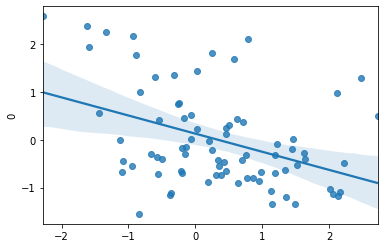

In [278]:
sns.regplot(yearly_anomalies.anomaly_train.values.reshape(-1,1), y)

In [384]:
yearly_anomalies.anomaly_train.values

array([-0.93290101, -0.20026173,  0.71953536,  0.45341851,  0.62010979,
        0.45665727, -0.21932496, -0.55573248, -0.06388839,  0.31042974,
        0.95607621, -0.60806289,  0.36175156, -0.14569198, -0.19870665,
        0.70056277,  0.38502094, -0.23733777, -0.35931926, -0.1528842 ,
        0.18484196, -0.53711605,  0.97889876, -0.38234582,  0.25431356,
       -1.43934804, -1.12251092,  0.20628976,  0.02543786, -0.50059054,
        0.86683365,  1.49273081, -0.31665982,  1.45246188,  1.6447259 ,
        0.6402415 , -0.83891472, -1.34178749, -0.88462912,  0.57817262,
       -0.94380472, -0.16291357, -1.62324191, -1.07596203,  0.50732855,
       -0.26045919, -0.57401586, -0.66477941,  1.19251707,  1.3548345 ,
        0.01989808, -0.82701902, -2.27826764, -1.09215606, -1.58334288,
        0.43257854,  0.46272937,  0.25109626,  2.16867783,  2.23007164,
        1.1851609 ,  2.1277734 ,  1.21804417,  1.61861467,  0.78249699,
        1.5178099 ,  1.15194634,  1.45998631,  0.7520314 , -0.07

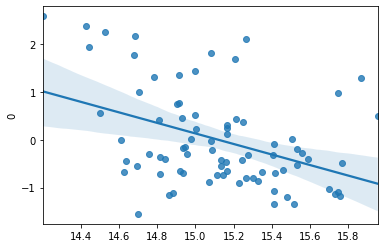

In [284]:
xnzi = df_nzi.groupby('year').temp.mean().values.reshape(-1,1)
sns.regplot(xnzi, y)

In [292]:
lm.fit(Xnzi[:50].reshape(-1,1), y[:50])
r2_score(y[50:], lm.predict(Xnzi[50:].reshape(-1,1)))

0.22624339534610383

In [385]:
xnzi_sep = yearly_anomalies.anomaly_train.values.reshape(-1,1)

In [401]:
lm = linear_model.LinearRegression()
A = np.arange(79).reshape(-1,1)
lm.fit(A[:50], xnzi_sep[:50])
lm.coef_

array([[-0.00352504]])

Text(0.5, 0, 'hi')

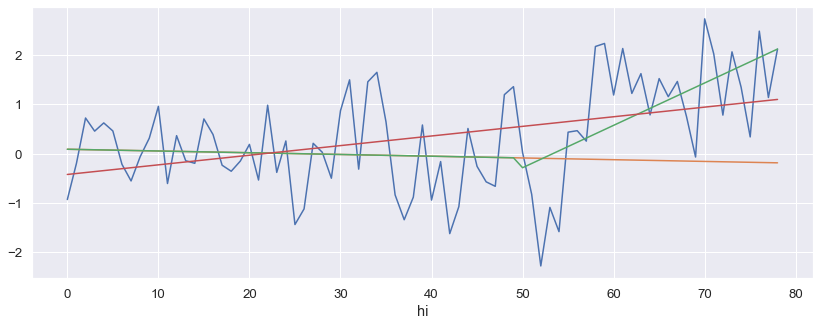

In [409]:
plt.figure(figsize=(14,5))
plt.plot(xnzi_sep)
plt.plot(lm.predict(A))
plt.plot(np.append(lm.predict(A[:50]), lm2.predict(A2)))
plt.plot(lm3.predict(A))

In [413]:
lm = linear_model.LinearRegression()
lm.fit(nzi_train, y[:50])
r2_score(y[50:], lm.predict(xnzi_sep[50:] - lm3.predict(xnzi_sep[50:])))

-0.28585535664141615

In [415]:
lm3.predict(xnzi_sep[50:])

array([[-0.42402727],
       [-0.44053392],
       [-0.46881917],
       [-0.44570152],
       [-0.45527489],
       [-0.41598401],
       [-0.41539636],
       [-0.41952115],
       [-0.38214694],
       [-0.38095035],
       [-0.40131596],
       [-0.38294417],
       [-0.40067506],
       [-0.39286782],
       [-0.409164  ],
       [-0.39483254],
       [-0.40196332],
       [-0.39595953],
       [-0.40975778],
       [-0.42580012],
       [-0.37123327],
       [-0.38514107],
       [-0.40924609],
       [-0.38426753],
       [-0.39820669],
       [-0.41785882],
       [-0.37608541],
       [-0.40229591],
       [-0.38316926]])

In [427]:
lm2 = linear_model.LinearRegression()
A2 = np.arange(29).reshape(-1,1)
lm2.fit(A2, xnzi_sep[50:])

LinearRegression()

In [422]:
lm3 = linear_model.LinearRegression()
A = np.arange(79).reshape(-1,1)
lm3.fit(A, xnzi_sep)

xnzi_full = xnzi_sep - lm3.predict(A)
yhat_full = lm.predict(xnzi_full)

In [ ]:
lm3 = linear_model.LinearRegression()
A = np.arange(79).reshape(-1,1)
lm3.fit(A, xnzi_sep)

xnzi_full = xnzi_sep - lm3.predict(A)

In [441]:
lm = linear_model.LinearRegression()
lm.fit(xnzi_full[:50], y[:50])
print(r2_score(y[50:], lm.predict(xnzi_full[50:])))

yhat1 = lm.predict(xnzi_full)

0.22163773931595498


In [428]:
nzi_train = xnzi_sep[:50] - lm.predict(A[:50])
nzi_test = xnzi_sep[50:] - lm.predict(A[50:])
nzi_test2 = xnzi_sep[50:] - lm2.predict(A2)

In [432]:
lm = linear_model.LinearRegression()
lm.fit(nzi_train, y[:50])
print(r2_score(y[50:], lm.predict(nzi_test)))
yhat2 = lm.predict(np.vstack([nzi_train, nzi_test]))

0.0002798243038891757


In [433]:
lm = linear_model.LinearRegression()
lm.fit(nzi_train, y[:50])
print(r2_score(y[50:], lm.predict(nzi_test2)))
yhat3 = lm.predict(np.vstack([nzi_train, nzi_test2]))

0.14948020559052977


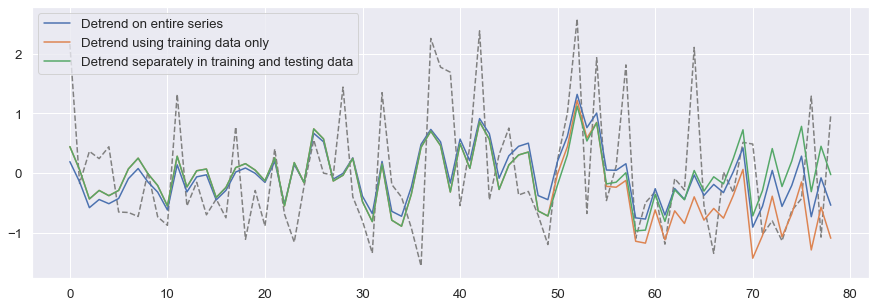

In [440]:
plt.figure(figsize=(15,5))
plt.plot(y, '--', color='grey')
plt.plot(yhat1, linewidth=1.5, label='Detrend on entire series')
plt.plot(yhat2, linewidth=1.5, label='Detrend using training data only')
plt.plot(yhat3, label='Detrend separately in training and testing data')
plt.legend()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(xnzi_sep, '--', color='black')
plt.plot(np.append(nzi_train, nzi_test), linewidth=1.5)
plt.plot(np.append(nzi_train, nzi_test2), linewidth=1.5)

array([[0.01949029]])

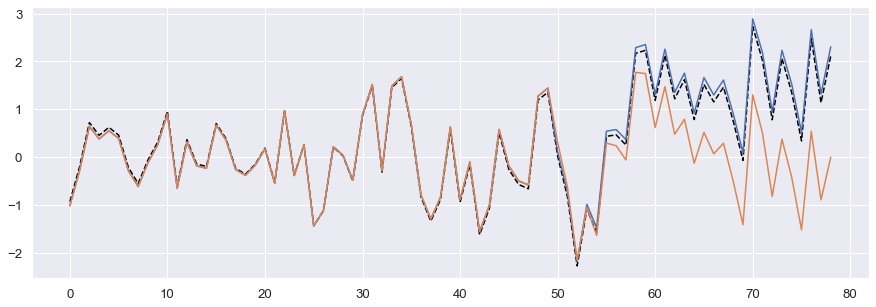

In [397]:
plt.figure(figsize=(15,5))
plt.plot(xnzi_sep, '--', color='black')
plt.plot(np.append(nzi_train, nzi_test), linewidth=1.5)
plt.plot(np.append(nzi_train, nzi_test2), linewidth=1.5)

In [353]:
X_train

array([[ 0.3315336 ,  0.0404144 ,  0.45568059, ..., -0.70675555,
         1.56414897,  1.46965927],
       [ 0.19555923,  0.519559  ,  0.87982311, ..., -1.36428409,
        -0.23171897, -0.8920282 ],
       [-0.07312825,  0.04052562, -0.04398697, ..., -0.54733897,
         0.56126365,  0.29053901],
       ...,
       [ 1.05660038,  1.82044534, -1.10340698, ..., -0.91569539,
         0.46964972,  0.9559261 ],
       [ 1.37573988,  1.73444937, -0.43476906, ...,  0.29710642,
        -0.05511318,  0.6961288 ],
       [ 2.18565761,  0.5041588 , -0.3448199 , ..., -0.41813335,
        -0.81451864, -0.20319629]])

In [349]:
lm2.coef_

array([[0.08588471]])

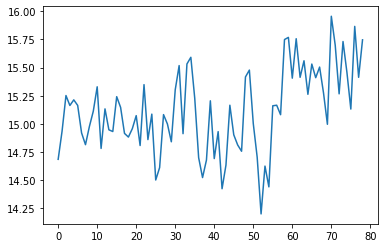

In [341]:
plt.plot(xnzi)

In [340]:
lm.fit(nzi_train, y[:50])
r2_score(y[50:], lm.predict(nzi_test2))

0.15003478016740823

In [324]:
lm.fit(A, Xnzi)

ValueError: Found input variables with inconsistent numbers of samples: [50, 79]

In [ ]:
plt.plot(np.arange(50), xnzi_sep[:50] - lm.predict(A))

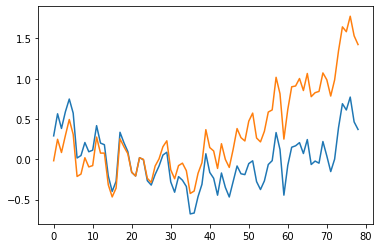

In [184]:
plt.plot(X_obs.mean(axis=1))
plt.plot(np.append(X_train_dt.mean(axis=1), X_test_dt.mean(axis=1)))

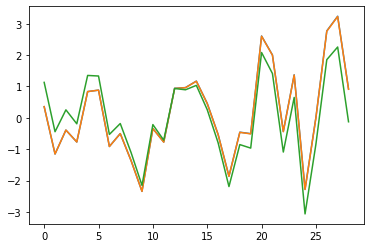

In [150]:
plt.plot(X_test[:, i])
plt.plot((X_test - A[-29:]@coef)[:,i])
plt.plot(signal.detrend(X_test, axis=0)[:, i])

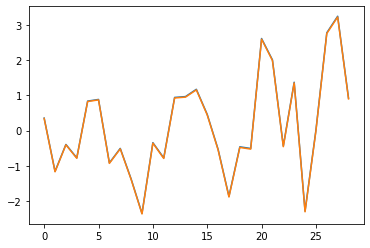

In [159]:
plt.plot(X_test[:, i])
plt.plot((X_test - A_test@coef)[:,i])
#plt.plot(signal.detrend(X_test, axis=0)[:, i])

In [160]:
X_test[:, i]

array([ 0.35554032, -1.15359088, -0.3905713 , -0.77017368,  0.83703074,
        0.88383257, -0.91357119, -0.50185431, -1.36790218, -2.34417735,
       -0.34033141, -0.77198278,  0.94092373,  0.96491735,  1.17125754,
        0.46128693, -0.52684842, -1.86132925, -0.45778622, -0.50450706,
        2.6095738 ,  2.00500993, -0.43449264,  1.37193973, -2.27838344,
        0.01266675,  2.7720149 ,  3.24039875,  0.92077703])

In [162]:
(X_test - A_test@coef)[:,i]

array([ 0.34502416, -1.16451944, -0.40191226, -0.78192704,  0.82486498,
        0.87125441, -0.92656175, -0.51525727, -1.38171753, -2.3584051 ,
       -0.35497156, -0.78703534,  0.92545878,  0.94904   ,  1.1549678 ,
        0.44458478, -0.54396297, -1.87885619, -0.47572556, -0.5228588 ,
        2.59080967,  1.9858334 , -0.45408158,  1.35193839, -2.29879717,
       -0.00815939,  2.75077637,  3.21874782,  0.8987137 ])

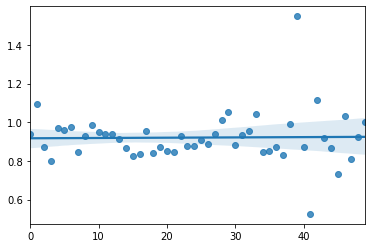

In [118]:
sns.regplot(x=np.arange(50), y=X_train[:, i])

In [72]:
data = X_train
axis= 0 
bp = 0

data = np.asarray(data)
dtype = data.dtype.char
if dtype not in 'dfDF':
    dtype = 'd'


dshape = data.shape
N = dshape[axis]
bp = np.sort(np.unique(np.r_[0, bp, N]))
if np.any(bp > N):
    raise ValueError("Breakpoints must be less than length "
                     "of data along given axis.")
Nreg = len(bp) - 1
# Restructure data so that axis is along first dimension and
#  all other dimensions are collapsed into second dimension
rnk = len(dshape)
if axis < 0:
    axis = axis + rnk
newdims = np.r_[axis, 0:axis, axis + 1:rnk]
newdata = np.reshape(np.transpose(data, tuple(newdims)),
                     (N, _prod(dshape) // N))
if not overwrite_data:
    newdata = newdata.copy()  # make sure we have a copy
if newdata.dtype.char not in 'dfDF':
    newdata = newdata.astype(dtype)
# Find leastsq fit and remove it for each piece

for m in range(Nreg):
    Npts = bp[m + 1] - bp[m]
    A = np.ones((Npts, 2), dtype)
    A[:, 0] = np.cast[dtype](np.arange(1, Npts + 1) * 1.0 / Npts)
    sl = slice(bp[m], bp[m + 1])
    coef, resids, rank, s = linalg.lstsq(A, newdata[sl])
    newdata[sl] = newdata[sl] - np.dot(A, coef)
# Put data back in original shape.
tdshape = np.take(dshape, newdims, 0)
ret = np.reshape(newdata, tuple(tdshape))
vals = list(range(1, rnk))
olddims = vals[:axis] + [0] + vals[axis:]
ret = np.transpose(ret, tuple(olddims))

ImportError: cannot import name 'prod' from 'scipy._lib._util' (/Users/abbystevens/.virtualenvs/gtv/lib/python3.7/site-packages/scipy/_lib/_util.py)

In [76]:
data.dtype.char

'd'

In [53]:
n, p = X_train.shape
T = np.arange(n).reshape(-1,1)
for i in range(p):
    coef, resids, rank, s = linalg.lstsq(T, newdata[sl])
    newdata[sl] = newdata[sl] - np.dot(A, coef)

array([[-0.44367696, -0.44371483, -0.44377871, ..., -0.44352547,
        -0.44339407, -0.44326083],
       [-0.24812769, -0.24800436, -0.24812207, ..., -0.24774435,
        -0.24766213, -0.24796044],
       [-0.26808767, -0.26808119, -0.26809385, ..., -0.26810198,
        -0.2680917 , -0.26809343],
       ...,
       [ 3.18653942,  3.19093263,  3.18566573, ...,  3.18827853,
         3.18012619,  3.185201  ],
       [ 3.18846387,  3.21626915,  3.20400502, ...,  3.20523883,
         3.21368307,  3.22527601],
       [ 6.14033819,  6.17009352,  6.15517616, ...,  6.14664568,
         6.15006801,  6.16132655]])

(array([  6.,   8.,  15.,  51., 132., 215., 304., 174.,  31.,   4.]),
 array([-2.66475921e-02, -2.22115528e-02, -1.77755135e-02, -1.33394741e-02,
        -8.90343482e-03, -4.46739550e-03, -3.13561739e-05,  4.40468315e-03,
         8.84072248e-03,  1.32767618e-02,  1.77128011e-02]),
 <a list of 10 Patch objects>)

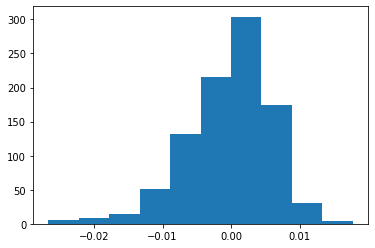

In [46]:
plt.hist(idk[0])

(array([ 27.,  70.,  74.,  73.,  94.,  55.,  50.,  95., 135., 267.]),
 array([-0.44295376,  2.56396003,  5.57087382,  8.57778761, 11.5847014 ,
        14.59161519, 17.59852897, 20.60544276, 23.61235655, 26.61927034,
        29.62618413]),
 <a list of 10 Patch objects>)

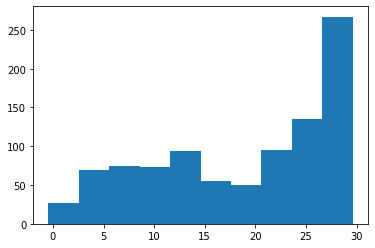

In [47]:
plt.hist(idk[1])

In [23]:
def detrend_and_scale(df, min_year, training_end, max_year):
    # min_ and max_year inclusive
    seasonal = df[(df.year.between(min_year, training_end))
                 ].groupby(['lat', 'lon', 'month']).val.agg(['mean', 'std']).reset_index()
    sst = pd.merge(df, seasonal, on=['lat', 'lon', 'month'])
    sst['anomaly'] = (sst['val'] - sst['mean'])/sst['std']
    sst['val'] = sst['anomaly']
    # aggregate to 10x10 temporal scale, stack into matrix, scale
    X_train, fts, _ = monthly_X(sst, step=10, agg=True, scale=False, max_year=training_end)
    X_test, _, _ = montyly_X(sst, step=10, agg=True, scale=Fale, min_year=training_end+1, max_year=2018)
    
    X = preprocessing.scale(signal.detrend(X, axis=0))
    return X, fts

,lat,lon,time,temp,year,month,var,val
76,60,155,0,-1.463,1940,jan,sst,-1.463
77,60,156,0,-1.425,1940,jan,sst,-1.425
78,60,157,0,-1.391,1940,jan,sst,-1.391
79,60,158,0,-1.285,1940,jan,sst,-1.285
80,60,159,0,-1.217,1940,jan,sst,-1.217
...,...,...,...,...,...,...,...,...
23056303,-59,275,11,4.927,2018,dec,sst,4.927
23056304,-59,276,11,4.967,2018,dec,sst,4.967
23056305,-59,277,11,5.012,2018,dec,sst,5.012
23056306,-59,278,11,4.991,2018,dec,sst,4.991


In [5]:
# separately detrend train/test periods
X_train, fts_obs = detrend_and_scale(df, 1940, 1989)
X_test, _ = detrend_and_scale(df, 1990, 2019)

In [19]:
X_obs, _ = detrend_and_scale(df, 1940, 2019)

# LENS

#### Download raw data [here](https://drive.google.com/drive/u/1/folders/1ddwOm4wIt6A8-_y9KxI0OdSTqTamhK8i)

The file 'surf_temp.mat' includes monthly data of surface temperature (in Kelvin) over the Pacific Ocean during 01/1920-12/2005, for all 40 ensembles from LENS.

The Pacific has been defined as:

   - Latitudes: 60S-60N
   - Longitudes: 80E-280E
   
Particularly, the file 'surf_temp.mat' contains: 

   - 4D matrix 'TS': 128 by 161 by 1032 by 40
   - vector 'lat': 128 by 1 which corresponds to the latitudinal points over Pacific 
   - vector 'lon': 161 by 1 which corresponds to the longitudinal points over Pacific 

In [11]:
# load .mat file
surf_temp = {}
with h5py.File('/Users/abbystevens/Downloads/surf_temp.mat', 'r') as f:
    for k, v in f.items():
        surf_temp[k] = np.array(v)

In [12]:
surf_temp['TS'].shape

(40, 1032, 161, 128)

First, we interpolate LENS onto the same grid as the observations

In [13]:
from scipy.interpolate import RegularGridInterpolator

lats = surf_temp['lat'][0].copy() #128
lons = surf_temp['lon'][0].copy() #161

# define grid to interpolate 
x = lons.copy()
y = lats.copy()
z = np.arange(surf_temp['TS'].shape[1])

# create grid to interpolate onto
pts = np.array([i for i in itertools.product(z, obs_lons, obs_lats)])

iLENS = np.zeros((40, z.shape[0], obs_lons.shape[0], obs_lats.shape[0])) #initialize empty array

In [14]:
# iterate through trajectories and interpolate
for i in range(40):
    if i%10==0: print(i)
    lens = surf_temp['TS'][i] # extract ith trajectory
    rgi = RegularGridInterpolator((z, x, y), lens, bounds_error=False, fill_value=None) #train interpolator
    ilens = rgi(pts).reshape(z.shape[0], obs_lons.shape[0], obs_lats.shape[0]) #interpolate onto new points
    iLENS[i] = ilens

0
10
20
30


In [18]:
lens = iLENS[0]
lens_df = flatten_lens(lens, obs_lats, obs_lons, 1920)
lens_df['trajectory'] = 0
lens_df = lens_df[lens_df.month.isin(['july', 'aug', 'sept', 'oct'])]
for i in range(1,40):
    if i%10 == 0:
        print(i)
    lens = iLENS[i]
    flat_df = flatten_lens(lens, obs_lats, obs_lons, 1920)
    flat_df = flat_df[flat_df.month.isin(['july', 'aug', 'sept', 'oct'])]
    flat_df['trajectory'] = i
    lens_df = lens_df.append(flat_df, ignore_index=True)

10
20
30


In [26]:
lens0 = lens_df[lens_df.trajectory==0]
Xlens, fts_lens = detrend_and_scale(lens0, 1940, 1989)
for i in range(1, 40):
    if i%10==0: print('finished ', i)
    lensi = lens_df[lens_df.trajectory==i]
    Xi, _ = detrend_and_scale(lensi, 1940, 1989)
    Xlens = np.vstack([Xlens, Xi])
print('done')

finished 10
finished 20
finished 30
done


In [603]:
def window_trends(df, window, min_year, max_year):
    dt = pd.DataFrame()
    for yr in np.arange(min_year+window, max_year):
        t = df[df.year==yr]
        prev = df[df.year.between(yr-window, yr-1)].groupby(['lat', 'lon', 'month']).val.agg(['mean', 'std'])
        prev['year'] = yr
        t = pd.merge(t, prev, on=['lat', 'lon', 'month', 'year'])
        t['anomaly'] = (t.val - t['mean'])/t['std']
        dt = dt.append(t, ignore_index=True)

    dt['val'] = dt.anomaly
    X = np.vstack(dt.groupby('year').val.apply(np.array))
    fts = dt.drop_duplicates(['lat', 'lon', 'month'])
    # NZI/ENSO flags
    fts.loc[:, 'nzi'] = 0
    fts.loc[:, 'enso'] = 0
    fts.loc[(fts.lat.isin(range(-40, -26))) & (fts.lon.isin(range(170, 201))), 'nzi'] = 1
    fts.loc[(fts.lat.isin(range(-5, 5))) & (fts.lon.isin(range(160, 210))), 'enso'] = 3
    fts.loc[(fts.lat.isin(range(-5, 5))) & (fts.lon.isin(range(210, 270))), 'enso'] = 4
    fts.loc[(fts.lat.isin(range(-5, 5))) & (fts.lon.isin(range(190, 240))), 'enso'] = 3.4
    fts = fts.reset_index().drop('index', axis=1)
    
    #X, fts, _ = monthly_X(dt, step=10, agg=True, scale=False)
    return X, fts

def upscale(df, step=10):
    to_bin = lambda x: np.floor(x / step) * step + step / 2
    df.loc[:, "lat"] = df.lat.map(to_bin)
    df.loc[:, "lon"] = df.lon.map(to_bin)
    mdf = df.groupby(['lat', 'lon', 'year', 'month']).val.mean().reset_index()
    return mdf

In [559]:
lens_df = pd.read_csv('lens_df_10_summer.csv')
lens0 = upscale(lens_df[lens_df.trajectory==0])

In [569]:
lens0 = upscale(lens_df[lens_df.trajectory==0])

In [588]:
X0, fts0 = window_trends(lens0, 10, 1930, 1990)

In [593]:
lens_df = pd.read_csv('lens_df_10_summer.csv')
lens0 = upscale(lens_df[lens_df.trajectory==0])
Xlens, fts_lens = window_trends(lens0, 10, 1930, 1990)
for i in range(1, 40):
    print(i)
    if i % 10 == 0 and i < 30:
        lens_df = pd.read_csv('lens_df_{}_summer.csv'.format(str(i+10)))
    elif i == 30:
        lens_df = pd.read_csv('lens_df_39_summer.csv')
    lensi = upscale(lens_df[lens_df.trajectory==i])
    Xi, _ = window_trends(lensi, 10, 1930, 1990)
    Xlens = np.vstack([Xlens, Xi])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


AttributeError: module 'pandas' has no attribute 'read_cv'

In [607]:
_, fts_lens = window_trends(lensi, 10, 1930, 1990)

In [608]:
fts_lens

,lat,lon,year,month,val,mean,std,anomaly,nzi,enso
0,-55.0,75.0,1940,aug,0.087028,270.452798,1.105488,0.087028,0,0.0
1,-55.0,75.0,1940,july,0.660602,270.961095,1.492464,0.660602,0,0.0
2,-55.0,75.0,1940,oct,0.505555,271.432616,0.789594,0.505555,0,0.0
3,-55.0,75.0,1940,sept,1.053903,270.452345,0.625816,1.053903,0,0.0
4,-55.0,85.0,1940,aug,-0.318324,271.506281,0.915133,-0.318324,0,0.0
...,...,...,...,...,...,...,...,...,...,...
1087,65.0,265.0,1940,sept,0.863872,279.179435,1.067647,0.863872,0,0.0
1088,65.0,275.0,1940,aug,-0.053444,278.767410,0.504129,-0.053444,0,0.0
1089,65.0,275.0,1940,july,-2.570263,274.705379,0.356369,-2.570263,0,0.0
1090,65.0,275.0,1940,oct,0.528300,276.725851,0.430337,0.528300,0,0.0


In [595]:
for i in range(30, 40):
    print(i)
    if i % 10 == 0 and i < 30:
        lens_df = pd.read_csv('lens_df_{}_summer.csv'.format(str(i+10)))
    elif i == 30:
        lens_df = pd.read_csv('lens_df_39_summer.csv')
    lensi = upscale(lens_df[lens_df.trajectory==i])
    Xi, _ = window_trends(lensi, 10, 1930, 1990)
    Xlens = np.vstack([Xlens, Xi])

30
31
32
33
34
35
36
37
38
39


In [606]:
fts_lens.drop_duplicates(['lat', 'lon', 'month']).reset_index()

,index,lat,lon,year,month,val,mean,std,anomaly,lens_ix
0,0,-55.0,75.0,1940,aug,0.502495,270.132760,1.383315,0.502495,0
1,1,-55.0,75.0,1940,july,1.347346,271.842980,1.085227,1.347346,1
2,2,-55.0,75.0,1940,oct,-0.120904,271.807538,0.820273,-0.120904,2
3,3,-55.0,75.0,1940,sept,-0.257308,270.706036,1.145518,-0.257308,3
4,4,-55.0,85.0,1940,aug,0.652131,271.521376,1.200553,0.652131,4
...,...,...,...,...,...,...,...,...,...,...
1087,1087,65.0,265.0,1940,sept,1.280284,278.688348,1.057554,1.280284,1087
1088,1088,65.0,275.0,1940,aug,-0.775033,278.115939,1.231208,-0.775033,1088
1089,1089,65.0,275.0,1940,july,-0.603865,274.287692,1.042913,-0.603865,1089
1090,1090,65.0,275.0,1940,oct,0.077669,276.183078,0.448122,0.077669,1090


#### Overlap LENS and Obs 

The land was removed in the obs dataset but not LENS - overlap features for consistency

In [609]:
fts_lens = pd.read_csv('ftslens.csv')
fts_lens.shape

(1092, 5)

In [610]:
# store indices and merge
fts_lens['lens_ix'] = fts_lens.index
fts_obs['obs_ix'] = fts_obs.index
fts = pd.merge(fts_lens, fts_obs)


# remove some additional land
#fts = fts.loc[~((fts.lon > 250) & (fts.lat > 40))]
#fts = fts[(fts.lon!=75)&~((fts.lat==-25)&(fts.lon==145))&~((fts.lat==35)&(fts.lon==115))]

In [615]:
pd.DataFrame(Xlens).to_csv('../data/Xlens_window.csv', index=False)

In [10]:
#Xlens = Xlens[:, fts.lens_ix]
X_train = X_train[:, fts.obs_ix]
X_test = X_test[:, fts.obs_ix]

In [16]:
pd.DataFrame(X_train).to_csv('../data/X_train2.csv', index=False)
pd.DataFrame(X_test).to_csv('../data/X_test2.csv', index=False)

In [17]:
fts.to_csv('../data/fts2.csv')